In [3]:
#!/usr/bin/env python3
# 53907afe-531b-11ea-a595-00505601122b
# b7ea974c-d389-11e8-a4be-00505601122b

# 1. Setup

## 1.1. FS/OS requirements

In [1]:
!cp /kaggle/input/speech-recognition-school/common_voice_cs.py /kaggle/working/common_voice_cs.py
!cp /kaggle/input/speech-recognition-school/speech_recognition.py /kaggle/working/speech_recognition.py
!cp /kaggle/input/speech-recognition-school/common_voice_cs.dev.tfrecord /kaggle/working/common_voice_cs.dev.tfrecord
!cp /kaggle/input/speech-recognition-school/common_voice_cs.test.tfrecord /kaggle/working/common_voice_cs.test.tfrecord
!cp /kaggle/input/speech-recognition-school/common_voice_cs.train.tfrecord /kaggle/working/common_voice_cs.train.tfrecord

In [2]:
#!pip install -U tensorflow-gpu==2.8 tensorflow-addons==0.16.1 tensorflow-probability==0.16.0 tensorflow-hub==0.12.0 scipy
!pip freeze | grep tensorflow

tensorflow @ file:///opt/conda/conda-bld/dlenv-tf-2-6-gpu_1639878970787/work/tensorflow-2.6.2-cp37-cp37m-linux_x86_64.whl
tensorflow-addons==0.14.0
tensorflow-cloud==0.1.14
tensorflow-datasets==4.3.0
tensorflow-estimator==2.6.0
tensorflow-gcs-config==2.6.0
tensorflow-hub==0.12.0
tensorflow-io==0.21.0
tensorflow-metadata==1.5.0
tensorflow-probability==0.14.1
tensorflow-serving-api==2.7.0
tensorflow-transform==1.5.0


## 1.2. Python imports

In [2]:
import argparse
import datetime
import os
import re

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import fasttext
import fasttext.util

from common_voice_cs import CommonVoiceCs

## 1.3. Language embeddings

## 1.4. Args

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=None, type=int, help="Batch size.")
parser.add_argument("--epochs", default=None, type=int, help="Number of epochs.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument("--threads", default=1, type=int, help="Maximum number of threads to use.")
parser.add_argument("--checkpoints_period", default=None, type=int, help="Checkpoint callback period.")
parser.add_argument("--stopping_patience", default=None, type=int, help="Early stopping epochs patience.")
parser.add_argument("--label_smoothing", default=None, type=float, help="")
parser.add_argument("--learning_rate", default=0.01, type=float, help="Initial model learning rate.")

args = parser.parse_args([
    '--batch_size=128',
    '--epochs=20',
    '--checkpoints_period=3',
    '--stopping_patience=3',
    '--learning_rate=0.01'
] if "__file__" not in globals() else None)

# Create logdir name
args.logdir = os.path.join(
    "logs",
    "{}-{}-{}".format(
        os.path.basename(globals().get("__file__", "notebook")),
        datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S"),
        ",".join(
            (
                "{}={}".format(re.sub("(.)[^_]*_?", r"\1", k), v)
                for k, v in sorted(vars(args).items())
            )
        ),
    ),
)

tf.random.set_seed(args.seed) # tf2.6 (I have gpu issues on tf2.8 unfortunately)
tf.config.threading.set_inter_op_parallelism_threads(args.threads)
tf.config.threading.set_intra_op_parallelism_threads(args.threads)

args

Namespace(batch_size=128, checkpoints_period=3, epochs=20, label_smoothing=None, learning_rate=0.01, logdir='logs/notebook-2022-04-19_115710-bs=128,cp=3,e=20,ls=None,lr=0.01,s=42,sp=3,t=1', seed=42, stopping_patience=3, threads=1)

In [34]:
args.decay_steps = int(args.epochs * cvcs.train.cardinality() / args.batch_size)

# 2. Data

In [4]:
cvcs = CommonVoiceCs()
args.decay_steps = int(args.epochs * cvcs.train.cardinality() / args.batch_size)

In [5]:
def create_dataset(name):
    def prepare_example(example):
        # TODO: Create suitable batch examples.
        # - example["mfccs"] should be used as input
        # - the example["sentence"] is a UTF-8-encoded string with the target sentence
        #   - split it to unicode characters by using `tf.strings.unicode_split`
        #   - then pass it through the `cvcs.letters_mapping` layer to map
        #     the unicode characters to ids
        return (
            example["mfccs"],
            tf.cast(cvcs.letters_mapping(tf.strings.unicode_split(example["sentence"], "UTF-8")), tf.int32)
        )

    dataset = getattr(cvcs, name).map(prepare_example)
    dataset = dataset.shuffle(len(dataset), seed=args.seed) if name == "train" else dataset
    dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(args.batch_size))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train, dev, test = create_dataset("train"), create_dataset("dev"), create_dataset("test")

# 3. Model

In [8]:
class Model(tf.keras.Model):
    def __init__(self, args: argparse.Namespace) -> None:
        inputs = tf.keras.layers.Input(shape=[None, CommonVoiceCs.MFCC_DIM], dtype=tf.float32, ragged=True)
        
        inp = inputs
        for size in [256, 128, 64]:
            sequences = tf.keras.layers.Bidirectional(
                tf.keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(size, recurrent_dropout=0.2, dropout=0.05),return_sequences=True, return_state=False),
                merge_mode="sum"
            )(inp)
            inp = tf.keras.layers.Concatenate()([inp, sequences])
            
        logits = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1 + len(CommonVoiceCs.LETTERS), activation=None)
        )(sequences)
        
        super().__init__(inputs=inputs, outputs=logits)

        self.compile(optimizer=tf.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.CosineDecay(args.learning_rate, args.decay_steps)),
                     loss=self.ctc_loss,
                     metrics=[CommonVoiceCs.EditDistanceMetric()])

        self.callbacks = list()
        self.tb_callback = tf.keras.callbacks.TensorBoard(args.logdir)
        self.callbacks.append(self.tb_callback)
        if args.checkpoints_period:
            self.checkpoints = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, period=args.checkpoints_period) 
            self.callbacks.append(self.checkpoints)
        if args.stopping_patience:
            self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=args.stopping_patience)
            self.callbacks.append(self.early_stopping)

    def ctc_loss(self, gold_labels: tf.RaggedTensor, logits: tf.RaggedTensor) -> tf.Tensor:
        assert isinstance(gold_labels, tf.RaggedTensor), "Gold labels given to CTC loss must be RaggedTensors"
        assert isinstance(logits, tf.RaggedTensor), "Logits given to CTC loss must be RaggedTensors"

        return tf.reduce_mean( 
            tf.nn.ctc_loss( 
                gold_labels.to_sparse(),
                tf.transpose(logits.to_tensor(), perm=[1, 0, 2]),
                label_length=None,
                logit_length=tf.cast(logits.row_lengths(), tf.int32),
                #logits_time_major=False,
                blank_index=-1 # TODO, check?
            ),
            axis=0
        )

    def ctc_decode(self, logits: tf.RaggedTensor) -> tf.RaggedTensor:
        assert isinstance(logits, tf.RaggedTensor), "Logits given to CTC predict must be RaggedTensors"

        predictions, _ = tf.nn.ctc_beam_search_decoder(
            tf.transpose(logits.to_tensor(), perm=[1, 0, 2]),
            tf.cast(logits.row_lengths(), tf.int32),
        )
        predictions = tf.RaggedTensor.from_sparse(predictions[0])

        assert isinstance(predictions, tf.RaggedTensor), "CTC predictions must be RaggedTensors"
        return predictions

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(x, y, y_pred) # TF2.6. COMPATIBILITY
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        return {"loss": metric.result() for metric in self.metrics if metric.name == "loss"}

    def predict_step(self, data):
        data = data[0] if isinstance(data, tuple) else data
        y_pred = self(data, training=False)
        y_pred = self.ctc_decode(y_pred)
        return y_pred

    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compute_loss(x, y, y_pred)
        y_pred = self.ctc_decode(y_pred)
        return self.compute_metrics(x, y, y_pred, None)
    
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        del x  # The default implementation does not use `x`.
        return self.compiled_loss(
            y, y_pred, sample_weight, regularization_losses=self.losses)
    
    def compute_metrics(self, x, y, y_pred, sample_weight):
        del x  # The default implementation does not use `x`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        # Collect metrics to return
        return_metrics = {}
        for metric in self.metrics:
            result = metric.result()
            if isinstance(result, dict):
                return_metrics.update(result)
            else:
                return_metrics[metric.name] = result
        return return_metrics

In [9]:
model = Model(args)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 256)    562176      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 269)    0           input_1[0][0]                    
                                                                 bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 128)    412160      concatenate[0][0]            

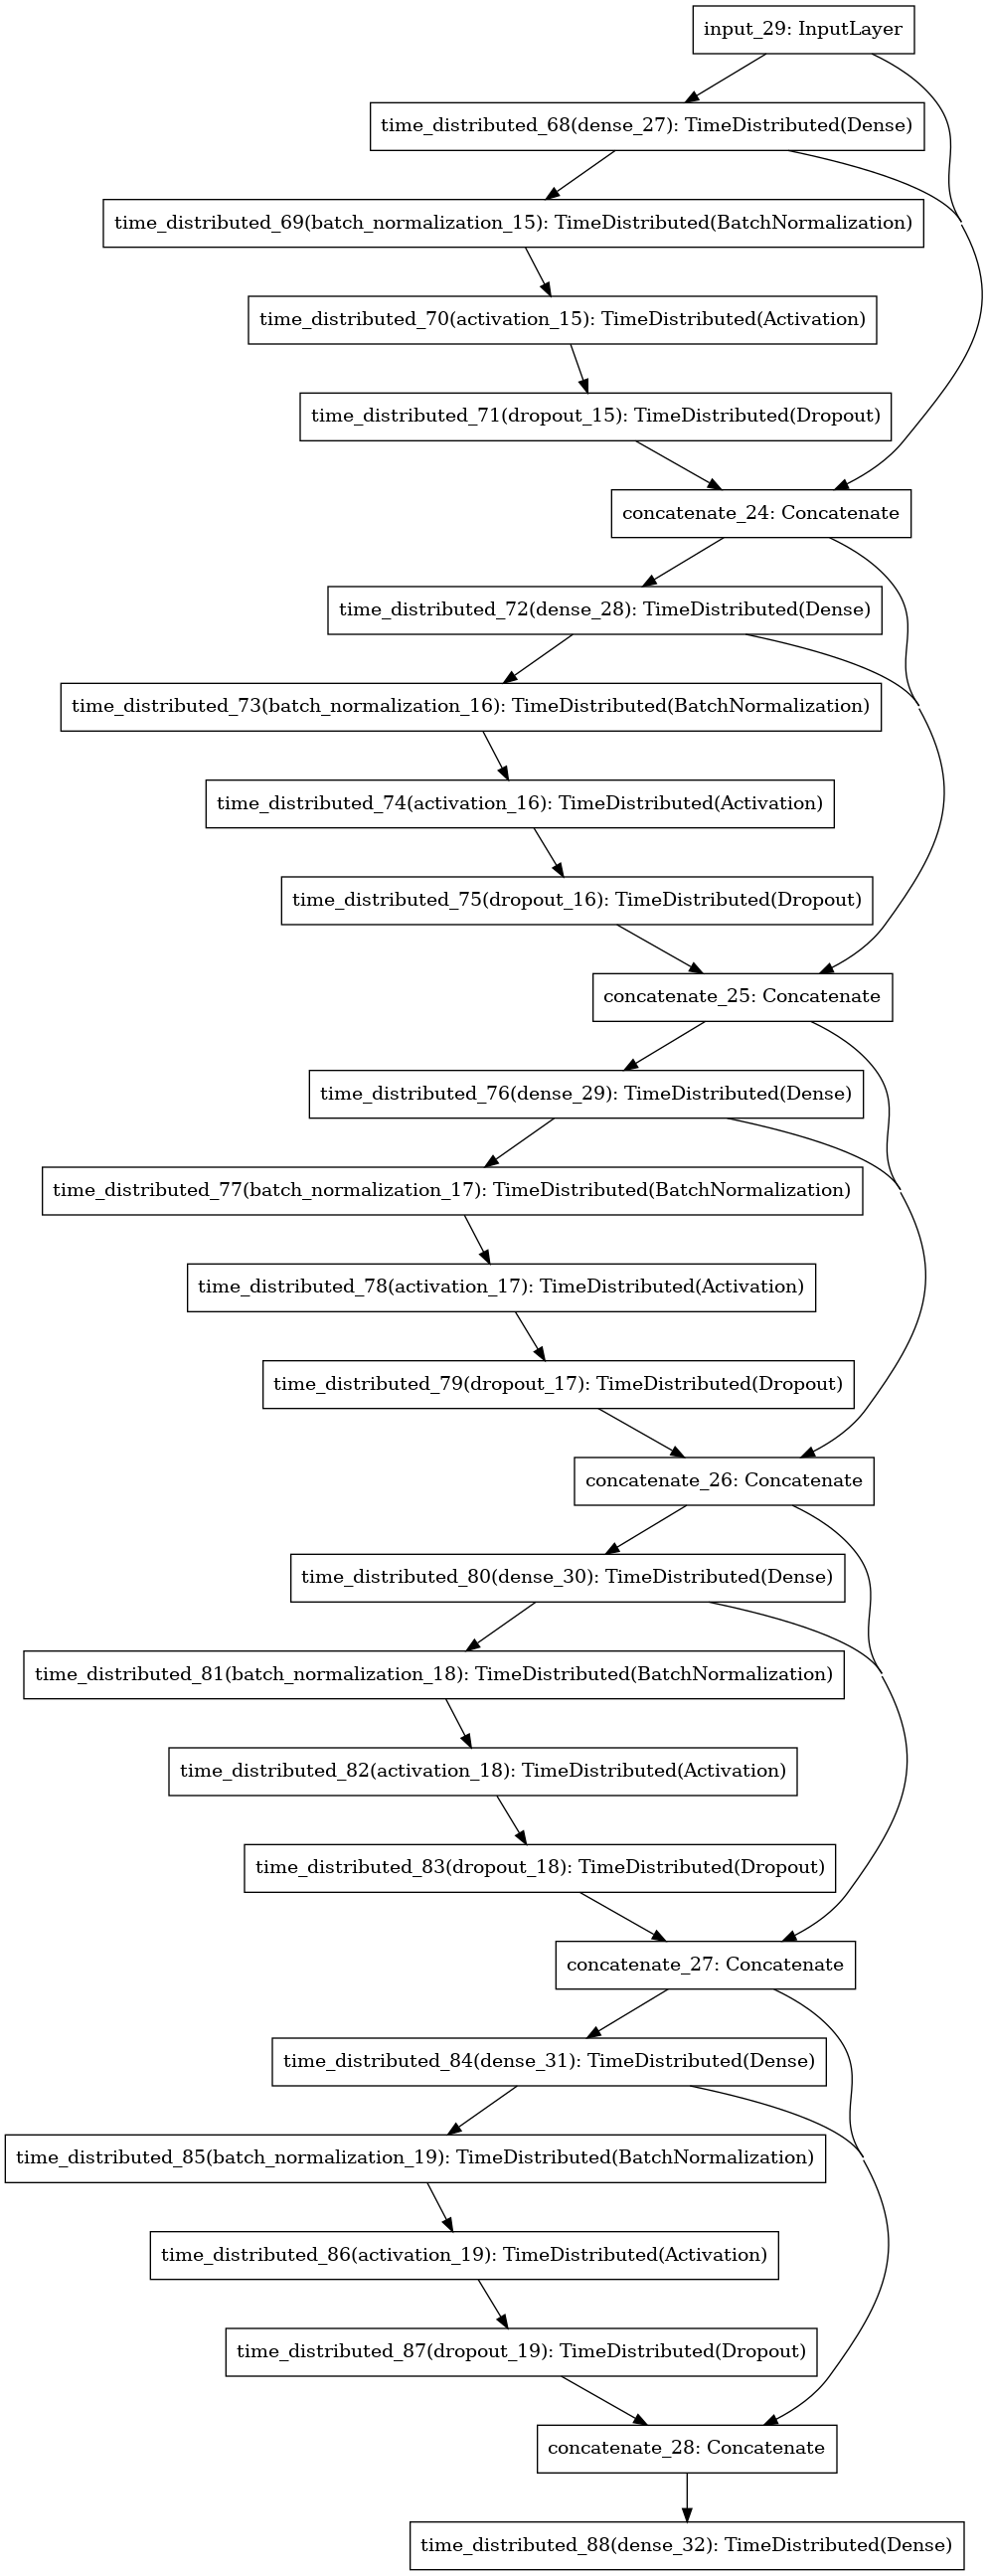

In [98]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [12]:
logs = model.fit(
    train, 
    epochs=args.epochs,
    validation_data=dev,
    shuffle=False,
    callbacks=[model.callbacks],
)

Epoch 1/20
77/77 [==============================] - 1498s 19s/step - loss: 109.0234 - val_loss: 92.8488 - val_edit_distance: 0.7346
Epoch 2/20
77/77 [==============================] - 1368s 18s/step - loss: 98.8193 - val_loss: 85.6414 - val_edit_distance: 0.6549
Epoch 3/20
77/77 [==============================] - 1399s 18s/step - loss: 91.2198 - val_loss: 79.8042 - val_edit_distance: 0.6230
Epoch 4/20
77/77 [==============================] - 1405s 18s/step - loss: 85.8931 - val_loss: 77.3522 - val_edit_distance: 0.5961
Epoch 5/20
77/77 [==============================] - 1383s 18s/step - loss: 82.9496 - val_loss: 76.5742 - val_edit_distance: 0.5880
Epoch 6/20
77/77 [==============================] - 1397s 18s/step - loss: 81.8522 - val_loss: 76.0160 - val_edit_distance: 0.5841
Epoch 7/20
77/77 [==============================] - 1387s 18s/step - loss: 81.7010 - val_loss: 76.0160 - val_edit_distance: 0.5841
Epoch 8/20
77/77 [==============================] - 1437s 19s/step - loss: 81.7522

KeyboardInterrupt: 

# 4. Predictions

In [13]:
# Generate test set annotations, but in `args.logdir` to allow parallel execution.
os.makedirs(args.logdir, exist_ok=True)
with open(os.path.join(args.logdir, "speech_recognition.txt"), "w", encoding="utf-8") as predictions_file:
    # TODO: Predict the CommonVoice sentences.
    predictions = model.predict(test)

    for sentence in predictions:
        print("".join(CommonVoiceCs.LETTERS[char] for char in sentence), file=predictions_file)

In [41]:
args.logdir

'logs/notebook-2022-04-18_135637-bs=128,cp=3,e=10,ls=None,lr=0.001,s=42,sp=3,t=1'